In [251]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 255)
import numpy as np
import datetime
import pytz
utc = pytz.utc # this is when creating a datetime and you need to set the tzinfo to utc
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import squarify

# kmodes
from kmodes.kmodes import KModes

# metrics and evaluation
from sklearn.metrics import silhouette_score 
from yellowbrick.cluster import SilhouetteVisualizer, silhouette_visualizer
from sklearn.metrics import calinski_harabasz_score
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import InterclusterDistance

# Import and Clean Data

In [252]:
# taking too long - using just 2021 now

In [253]:
# time cutoff
earliest_cutoff = datetime.datetime(2021,1,1,tzinfo=utc)

## Clickstream

In [254]:
# import data and clean
clickstream = pd.read_csv('clickstream.csv')
clickstream['email'] = clickstream['email'].apply(lambda x: str(x).lower())
clickstream['_time'] = pd.to_datetime(clickstream['_time'],
                                      utc=True)
clickstream = clickstream[clickstream['_time'] >= earliest_cutoff].reset_index(drop=True)

## Page Views

In [255]:
# import data and clean
page_views = pd.read_csv('page_views.csv')
page_views['email'] = page_views['email'].apply(lambda x: str(x).lower())
page_views['_time'] = pd.to_datetime(page_views['_time'],
                                     utc=True)
page_views = page_views[page_views['_time'] >= earliest_cutoff].reset_index(drop=True)

# drop MAGE and INDURE clicks
exclude_articles = ["MAGE", "INDURE Apps"]
page_views = page_views[~page_views['article_title'].isin(exclude_articles)].reset_index(drop=True)

C:\Users\bjane\miniconda3\envs\non-seq-clickstream-clustering\lib\site-packages\IPython\core\interactiveshell.py:3457: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [256]:
# function to define page view type
def page_view_type(project_id, headline_page_view):
    view_type = 0
    # check if portal view
    if project_id > 12 and project_id != 20000:
        view_type = "Page View - Portal"
    # check if coi headline view
    elif project_id <= 12 and headline_page_view == 1:
        view_type = "Page View - COI (Headline)"
    # check if coi non-headline view
    elif project_id <= 12 and headline_page_view == 0:
        view_type = "Page View - COI"
    # check if help page headline view
    elif project_id == 20000 and headline_page_view == 1:
        view_type = "Page View - Help Page (Headline)"
    # check if help page non-headline view
    elif project_id == 20000 and headline_page_view == 0:
        view_type = "Page View - Help Page"
        
    return view_type

In [257]:
# assign click type
page_views['click'] = page_views.apply(lambda row: page_view_type(row['project_id'], row['headlinePageView']),
                                       axis=1)

In [258]:
# final
page_views = page_views[['email', '_time', 'click']]

In [259]:
# dropy mystery clicks
page_views = page_views[page_views['click']!=0]

## Searches

In [260]:
# import data and clean
searches = pd.read_csv('searches.csv')
searches['email'] = searches['email'].apply(lambda x: str(x).lower())
searches['_time'] = pd.to_datetime(searches['_time'],
                                   utc=True)
searches = searches[searches['_time'] >= earliest_cutoff].reset_index(drop=True)

In [261]:
# assign click type
searches['click'] = searches['search_string'].apply(lambda string: "Search - Tag" if pd.isnull(string) else "Search - Query")

In [262]:
# final
searches = searches[['email', '_time', 'click']]

## File Downloads

In [263]:
# import data and clean
file_downloads = pd.read_csv('file_downloads.csv')
file_downloads['email'] = file_downloads['email'].apply(lambda x: str(x).lower())
file_downloads['_time'] = pd.to_datetime(file_downloads['_time'],
                                   utc=True)
file_downloads = file_downloads[file_downloads['_time'] >= earliest_cutoff].reset_index(drop=True)

C:\Users\bjane\miniconda3\envs\non-seq-clickstream-clustering\lib\site-packages\IPython\core\interactiveshell.py:3457: DtypeWarning: Columns (4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [264]:
# assign click type
file_downloads['click'] = "File Download"

In [265]:
file_downloads = file_downloads[['email', '_time', 'click']]

## Discover Filtering

In [266]:
# import and clean
discover_filtering = pd.read_csv('discover_filtering.csv')
discover_filtering['email'] = discover_filtering['email'].apply(lambda x: str(x).lower())
discover_filtering['_time'] = pd.to_datetime(discover_filtering['_time'],
                                   utc=True)
discover_filtering = discover_filtering[discover_filtering['_time'] >= earliest_cutoff].reset_index(drop=True)

# assign click type
discover_filtering['click'] = "Discover Filtering"

In [267]:
# transact together all events within 5 minutes of one another
df_transactions = discover_filtering.set_index('_time').groupby('email').rolling('5MIN').count()
unique_df_transactions = df_transactions[df_transactions['project_title']==1]

discover_filtering = unique_df_transactions.reset_index()[['email', '_time']]
discover_filtering['click'] = "Discover Filtering"

In [268]:
discover_filtering = discover_filtering[['email', '_time', 'click']]

# Assemble Clickstreams

## Append All Actions

In [269]:
# append
clickstream_final = clickstream.append(page_views).append(searches).append(file_downloads).append(discover_filtering)
# sort
clickstream_final = clickstream_final.sort_values(by=['email', '_time']).reset_index(drop=True)

## Define User Sessions

In [270]:
# mark if an event marks a news session - 240 minutes of inactivity marks new session
clickstream_final['new_session'] = clickstream_final.groupby('email')['_time'].apply(lambda x: x.diff().dt.seconds > 240*60)

In [271]:
# add session data
clickstream_final['session'] = clickstream_final.groupby('email')['new_session'].cumsum().astype('int')

## Experiment: Transact Together All Consecutive Clicks in Single Session

In [272]:
# 1. CREATE COLS WITH PREVIOUS EVENT AND PREVOIUS EVENT EMAIL AND PREVIOUS SESSION NUMBER
# 2. DROP WHERE EVENT==PREVIOUS EVENT AND SESSION NUMBER==PREVIOUS SESSION NUMBER

In [273]:
# add previous click col
clickstream_final['previous_click'] = clickstream_final.groupby(['email', 'session'])['click'].shift(1)

In [274]:
clickstream_final = clickstream_final[clickstream_final['previous_click']!=clickstream_final['click']]

# Find Most Common Number of Actions per Session - ON HOLD

In [275]:
# we can capture at least 75% of user sessions with the first 4 clicks, half with just 2 clicks 

In [276]:
clickstream_final.groupby(['email', 'session']).count()['_time'].describe()

count    162483.000000
mean          5.103574
std           5.586751
min           1.000000
25%           2.000000
50%           4.000000
75%           6.000000
max         259.000000
Name: _time, dtype: float64

In [277]:
np.percentile(clickstream_final.groupby(['email', 'session']).count()['_time'], np.arange(0, 100, 10))

array([ 1.,  1.,  2.,  2.,  3.,  4.,  4.,  5.,  7., 11.])

<AxesSubplot:>

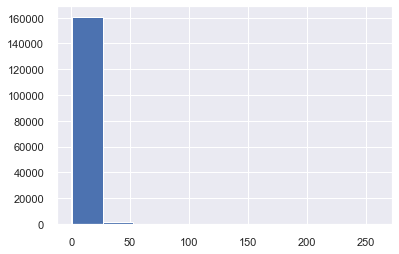

In [278]:
clickstream_final.groupby(['email', 'session']).count()['_time'].hist()

In [279]:
# look at first five events per session - ON HOLD
clickstream_final_first_3clicks = clickstream_final.groupby(['email', 'session']).head(3)
clickstream_final_first_4clicks = clickstream_final.groupby(['email', 'session']).head(4)
clickstream_final_first_5clicks = clickstream_final.groupby(['email', 'session']).head(5)

# Prepare Data for K-Mode Clustering

In [280]:
# create df of total clicks for each click type
dummies = pd.get_dummies(clickstream_final['click'])
combine = pd.concat([clickstream_final, dummies], axis=1)
clickstream_nonsequential_summaries = combine.groupby(['email', 'session']).sum().reset_index()

In [281]:
# features only
clickstream_nonsequential_summaries_features = clickstream_nonsequential_summaries.drop(['email', 'session', 'new_session'], axis=1)

In [282]:
# create binary version
clickstream_nonsequential_summaries_features_binary = clickstream_nonsequential_summaries_features.applymap(lambda x: 1 if x > 0 else 0)

# Clustering

## K-Modes

### Choosing Optimal Number Clusters

#### Elbow Method

In [283]:
# TAKES A WHILE TO RUN! - 5 or 7 clusters seems optimal for 2021 data

In [284]:
#model=KModes()
#visualizer = KElbowVisualizer(model, k=(3,15), timings= True)
#visualizer.fit(clickstream_nonsequential_summaries_features_binary)
#visualizer.show()

KeyboardInterrupt: 

#### Calinski-Harabasz Index

In [ ]:
# CH method shows about 5 clusters ideally using 2021 data

In [ ]:
model=KModes()
#visualizer = KElbowVisualizer(model, k=(3,15),metric='calinski_harabasz', timings= True)
#visualizer.fit(clickstream_nonsequential_summaries_features_binary)        # Fit the data to the visualizer
#visualizer.show()        # Finalize and render the figure

### Modeling - 7 Clusters

In [286]:
# kmodes - remove n_init
model = KModes(n_clusters=7, init='Huang', n_init=5, verbose=1, random_state=13)

clusters = model.fit_predict(clickstream_nonsequential_summaries_features_binary)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 40683, cost: 221248.0
Run 1, iteration: 2/100, moves: 8935, cost: 221248.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 25426, cost: 198792.0
Run 2, iteration: 2/100, moves: 2016, cost: 198792.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 24786, cost: 200467.0
Run 3, iteration: 2/100, moves: 422, cost: 200467.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 25736, cost: 215193.0
Run 4, iteration: 2/100, moves: 3847, cost: 215193.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 23552, cost: 197759.0
Run 5, iteration: 2/100, moves: 7944, cost: 196516.0
Run 5, iteration: 3/100, moves: 588, cost: 196516.0
Best run was n

In [287]:
clickstream_nonsequential_summaries_features_binary['cluster'] = clusters

#### Evaluating Cluster

##### Actions for Each Cluster

In [288]:
# create matrix with percentage of sessions which featured each click 
session_clicks_by_cluster = clickstream_nonsequential_summaries_features_binary.groupby('cluster').sum() / clickstream_nonsequential_summaries_features_binary.groupby('cluster').count()

<AxesSubplot:ylabel='cluster'>

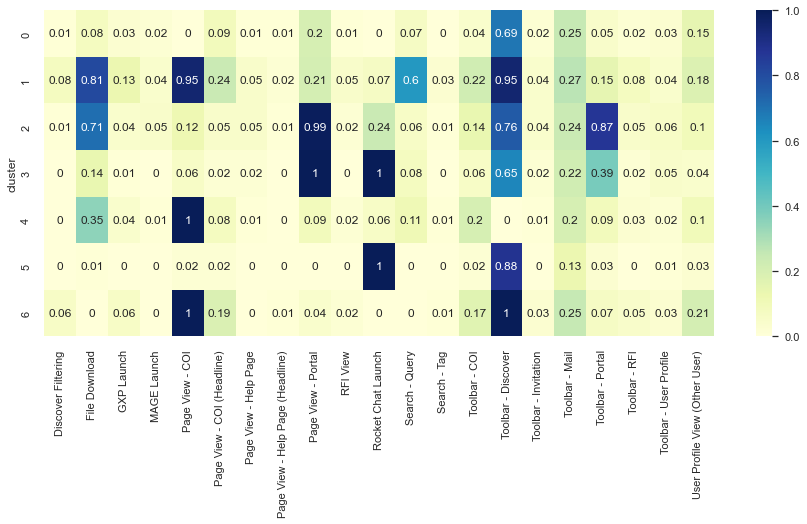

In [289]:
sns.set(rc = {'figure.figsize':(15,6)})
sns.heatmap(round(session_clicks_by_cluster,2), annot=True, cmap="YlGnBu")

##### Cluster Centroids and Sizes

In [290]:
# list of centroids with col names
cluster_centroids_with_col = [list(zip(clickstream_nonsequential_summaries_features_binary.columns, i)) for i in model.cluster_centroids_]

In [291]:
# cluster centroids
cluster_centroids = [[col[0] for col in cluster_centroid if col[1]] for cluster_centroid in cluster_centroids_with_col]

In [292]:
# cluster sizes 
cluster_sizes = clickstream_nonsequential_summaries_features_binary[['cluster', 'Discover Filtering']].groupby('cluster').count().rename(columns={'Discover Filtering': 'Total Sessions'})

In [293]:
# clusters 
clusters = list(range(0,len(cluster_centroids)))

In [294]:
# initialize df 
cluster_centroids_and_sizes = pd.DataFrame(columns=['Cluster', 'Centroids', 'Total Sessions'])

# add data
cluster_centroids_and_sizes['Cluster'] = clusters
cluster_centroids_and_sizes['Centroids'] = cluster_centroids
cluster_centroids_and_sizes['Total Sessions'] = cluster_sizes

In [295]:
# sort
cluster_centroids_and_sizes = cluster_centroids_and_sizes.sort_values(by='Total Sessions',
                                                                      ascending=False)

In [296]:
cluster_centroids_and_sizes

,Cluster,Centroids,Total Sessions
5,5,"[Rocket Chat Launch, Toolbar - Discover]",67392
0,0,[Toolbar - Discover],27811
1,1,"[File Download, Page View - COI, Search - Query, Toolbar - Discover]",20804
2,2,"[File Download, Page View - Portal, Toolbar - Discover, Toolbar - Portal]",19520
3,3,"[Page View - Portal, Rocket Chat Launch, Toolbar - Discover]",11825
6,6,"[Page View - COI, Toolbar - Discover]",7980
4,4,[Page View - COI],7151


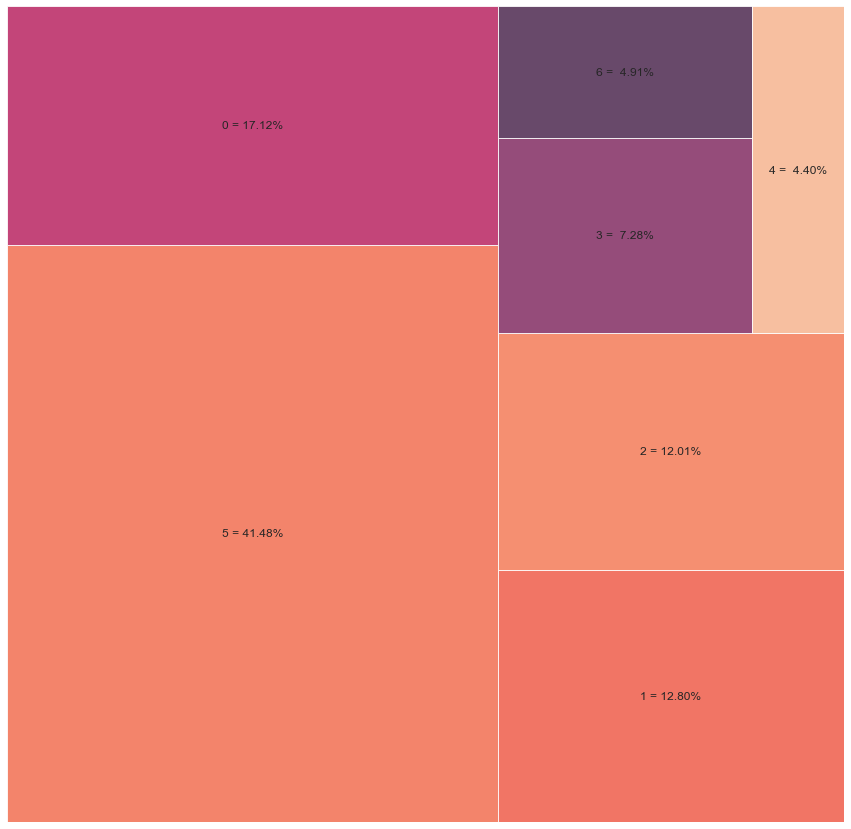

In [297]:
# plot and create labels
#squarify.plot(sizes=cluster_centroids_and_sizes['Total Sessions'], label=cluster_centroids_and_sizes['Cluster'], alpha=.8 )
perc = [f'{i/cluster_centroids_and_sizes["Total Sessions"].sum()*100:5.2f}%' for i in cluster_centroids_and_sizes['Total Sessions']]
lbl = [f'{el[0]} = {el[1]}' for el in zip(cluster_centroids_and_sizes['Cluster'], perc)]

sns.set(rc = {'figure.figsize':(15,15)})
squarify.plot(sizes=cluster_centroids_and_sizes['Total Sessions'], label=lbl, alpha=.8)
plt.axis('off')
plt.show();

##### Investigating Specific Cluster Sessions

In [298]:
# add session and email data to binary clickstream summaries
clickstreams_with_clusters = clickstream_nonsequential_summaries_features_binary.merge(clickstream_nonsequential_summaries[['email', 'session']],
                                                                                          how='left',
                                                                                          right_index=True,
                                                                                          left_index=True)

In [299]:
# add email and session data 
full_clickstreams_with_cluster = clickstream_final.merge(clickstreams_with_clusters[['email', 'session', 'cluster']], 
                                    on=['email', 'session'],
                                    how='left')

In [337]:
# look at sessions for cluster of interest
cluster_of_interest = 4

full_clickstreams_with_cluster[full_clickstreams_with_cluster['cluster'] == cluster_of_interest].head(50)

,email,_time,click,new_session,session,previous_click,cluster
56,00154435@mil.dk,2021-12-06 07:41:50+00:00,Page View - COI,True,6,NaN,4
57,00154435@mil.dk,2021-12-06 07:42:38+00:00,File Download,False,6,Page View - COI,4
58,00154435@mil.dk,2021-12-06 07:44:14+00:00,Page View - COI,False,6,File Download,4
72,00188185@mil.dk,2021-01-22 07:35:39+00:00,Page View - COI,False,0,NaN,4
73,00188185@mil.dk,2021-01-22 07:37:40+00:00,Toolbar - RFI,False,0,Page View - COI,4
74,00188185@mil.dk,2021-01-22 07:42:27+00:00,RFI View,False,0,Toolbar - RFI,4
75,00188185@mil.dk,2021-01-22 07:42:42+00:00,Page View - COI,False,0,RFI View,4
76,00188185@mil.dk,2021-01-25 04:56:09+00:00,Page View - COI,True,1,NaN,4
77,00188185@mil.dk,2021-01-25 04:58:59+00:00,File Download,False,1,Page View - COI,4
78,00188185@mil.dk,2021-01-25 05:00:53+00:00,Toolbar - RFI,False,1,File Download,4


##### Silhouette Score

In [301]:
silhouette_score(clickstream_nonsequential_summaries_features_binary.drop(['cluster'], axis=1),
                 clickstream_nonsequential_summaries_features_binary['cluster'])

0.33234142602611094

### Modeling - 5 Clusters

In [318]:
# kmodes - remove n_init
model2 = KModes(n_clusters=5, init='Huang', n_init=5, verbose=1, random_state=13)

clusters2 = model2.fit_predict(clickstream_nonsequential_summaries_features_binary.drop(['cluster'], axis=1))

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 33553, cost: 214559.0
Run 1, iteration: 2/100, moves: 11320, cost: 214559.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 26743, cost: 225280.0
Run 2, iteration: 2/100, moves: 9154, cost: 225280.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 30855, cost: 223098.0
Run 3, iteration: 2/100, moves: 15128, cost: 223098.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 0, cost: 224512.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 24219, cost: 222313.0
Run 5, iteration: 2/100, moves: 4421, cost: 222313.0
Best run was number 1


In [319]:
clickstream_nonsequential_summaries_features_binary['cluster2'] = clusters2

#### Evaluating Cluster

##### Actions for Each Cluster

In [320]:
# create matrix with percentage of sessions which featured each click 
session_clicks_by_cluster2 = clickstream_nonsequential_summaries_features_binary.groupby('cluster2').sum() / clickstream_nonsequential_summaries_features_binary.groupby('cluster2').count()

<AxesSubplot:ylabel='cluster2'>

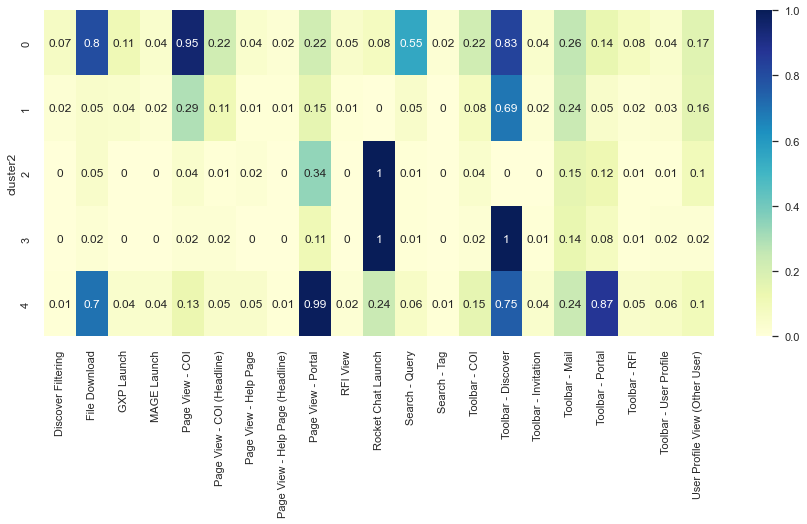

In [322]:
sns.set(rc = {'figure.figsize':(15,6)})
sns.heatmap(round(session_clicks_by_cluster2.drop(['cluster'], axis=1),2), annot=True, cmap="YlGnBu")

##### Cluster Centroids and Sizes

In [323]:
# list of centroids with col names
cluster_centroids_with_col2 = [list(zip(clickstream_nonsequential_summaries_features_binary.columns, i)) for i in model2.cluster_centroids_]

In [324]:
# cluster centroids
cluster_centroids2 = [[col[0] for col in cluster_centroid if col[1]] for cluster_centroid in cluster_centroids_with_col2]

In [325]:
# cluster sizes 
cluster_sizes2 = clickstream_nonsequential_summaries_features_binary[['cluster2', 'Discover Filtering']].groupby('cluster2').count().rename(columns={'Discover Filtering': 'Total Sessions'})

In [326]:
# clusters 
clusters2 = list(range(0,len(cluster_centroids2)))

In [327]:
# initialize df 
cluster_centroids_and_sizes2 = pd.DataFrame(columns=['Cluster', 'Centroids', 'Total Sessions'])

# add data
cluster_centroids_and_sizes2['Cluster'] = clusters2
cluster_centroids_and_sizes2['Centroids'] = cluster_centroids2
cluster_centroids_and_sizes2['Total Sessions'] = cluster_sizes2

In [328]:
# sort
cluster_centroids_and_sizes2 = cluster_centroids_and_sizes2.sort_values(by='Total Sessions',
                                                                        ascending=False)

In [329]:
cluster_centroids_and_sizes2

,Cluster,Centroids,Total Sessions
3,3,"[Rocket Chat Launch, Toolbar - Discover]",66835
1,1,[Toolbar - Discover],39234
0,0,"[File Download, Page View - COI, Search - Query, Toolbar - Discover]",24431
4,4,"[File Download, Page View - Portal, Toolbar - Discover, Toolbar - Portal]",19627
2,2,[Rocket Chat Launch],12356


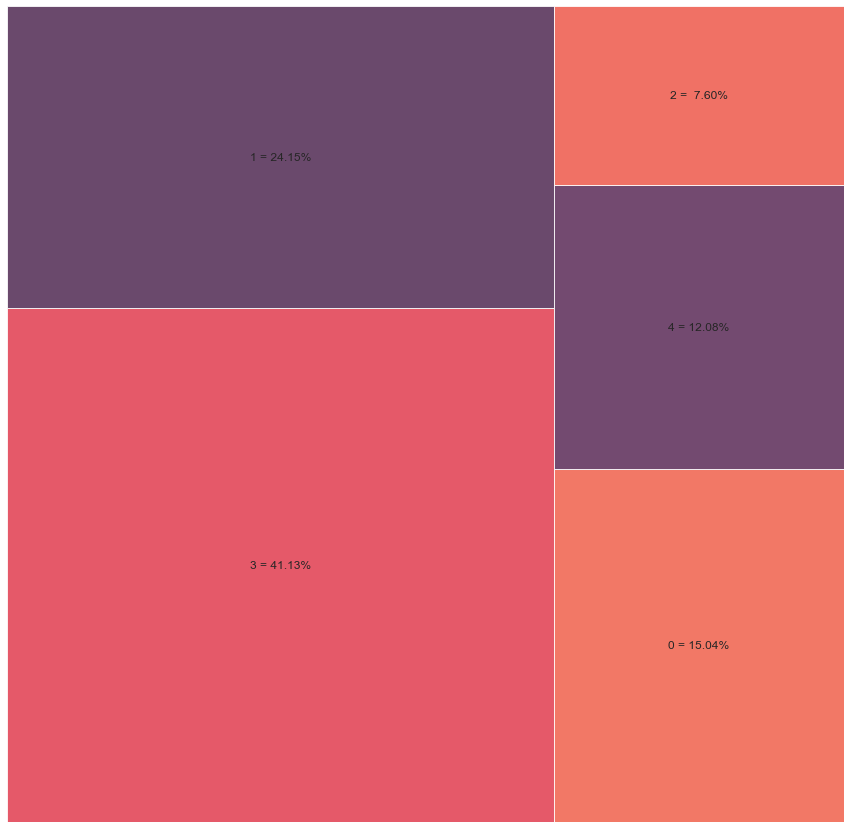

In [330]:
# plot and create labels
#squarify.plot(sizes=cluster_centroids_and_sizes['Total Sessions'], label=cluster_centroids_and_sizes['Cluster'], alpha=.8 )
perc2 = [f'{i/cluster_centroids_and_sizes2["Total Sessions"].sum()*100:5.2f}%' for i in cluster_centroids_and_sizes2['Total Sessions']]
lbl2 = [f'{el[0]} = {el[1]}' for el in zip(cluster_centroids_and_sizes2['Cluster'], perc2)]

sns.set(rc = {'figure.figsize':(15,15)})
squarify.plot(sizes=cluster_centroids_and_sizes2['Total Sessions'], label=lbl2, alpha=.8)
plt.axis('off')
plt.show();

##### Investigating Specific Cluster Sessions

In [331]:
# add session and email data to binary clickstream summaries
clickstreams_with_clusters2 = clickstream_nonsequential_summaries_features_binary.merge(clickstream_nonsequential_summaries[['email', 'session']],
                                                                                          how='left',
                                                                                          right_index=True,
                                                                                          left_index=True)

In [332]:
# add email and session data 
full_clickstreams_with_cluster2 = clickstream_final.merge(clickstreams_with_clusters2[['email', 'session', 'cluster2']], 
                                    on=['email', 'session'],
                                    how='left')

In [333]:
# look at sessions for cluster of interest
cluster_of_interest = 1

full_clickstreams_with_cluster2[full_clickstreams_with_cluster2['cluster2'] == cluster_of_interest].tail(50)

,email,_time,click,new_session,session,previous_click,cluster2
826958,zachary.r.taylor@nga.mil,2021-08-24 08:07:09+00:00,Rocket Chat Launch,True,147,NaN,2
826959,zachary.r.taylor@nga.mil,2021-08-25 13:27:10+00:00,Rocket Chat Launch,True,148,NaN,2
826960,zachary.r.taylor@nga.mil,2021-08-26 08:08:28+00:00,Rocket Chat Launch,True,149,NaN,2
826961,zachary.r.taylor@nga.mil,2021-08-27 08:07:17+00:00,Rocket Chat Launch,True,150,NaN,2
826962,zachary.r.taylor@nga.mil,2021-08-30 13:37:20+00:00,Rocket Chat Launch,True,151,NaN,2
826963,zachary.r.taylor@nga.mil,2021-08-31 08:06:20+00:00,Rocket Chat Launch,True,152,NaN,2
826964,zachary.r.taylor@nga.mil,2021-09-01 13:38:52+00:00,Rocket Chat Launch,True,153,NaN,2
826965,zachary.r.taylor@nga.mil,2021-09-02 08:07:56+00:00,Rocket Chat Launch,True,154,NaN,2
826966,zachary.r.taylor@nga.mil,2021-09-07 14:37:46+00:00,Rocket Chat Launch,True,155,NaN,2
826967,zachary.r.taylor@nga.mil,2021-09-08 09:05:31+00:00,Rocket Chat Launch,True,156,NaN,2


##### Silhouette Score

In [334]:
silhouette_score(clickstream_nonsequential_summaries_features_binary.drop(['cluster2', 'cluster'], axis=1),
                 clickstream_nonsequential_summaries_features_binary['cluster2'])

0.3055090865053114